In [1]:
from scipy.ndimage.morphology import binary_hit_or_miss
from scipy.ndimage import binary_fill_holes
from commonfunctions import *
import numpy as np
import os
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect
import scipy.stats
from skimage import draw
from skimage.morphology import(binary_erosion, 
                               binary_dilation,
                               binary_closing,
                               skeletonize,
                               thin,
                               opening
                              )
from skimage.measure import find_contours
from skimage.filters import rank
from skimage.draw import rectangle
from skimage.filters import threshold_otsu, gaussian
from skimage import feature

import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
import pickle 


In [2]:
import cv2
if ' ':
    print('hi')
    
def cv_show(image):
    image=np.uint8(image)
    cv2.imshow("image", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

hi


In [3]:
# classes
class staff_meta(object):
    division_height = -1
    line_thickness = -1
    staff_lines_y_coords = []


random_seed = 42  
random.seed(random_seed)
np.random.seed(random_seed)

# Classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=7),
    'SVM': svm.LinearSVC(random_state=random_seed)
}

class notes_pitch(object):
    char =   ['e','f','g','a','b','c','d','e','f']
    factor = [ 1 , 1 , 1 , 1 , 1 , 2 , 2 , 2 , 2 ]
    

In [4]:
# Functions Used in Image Processing 
def get_noteLine_depending_height(centers,boxes_start_point,trace_info):
    #trace_info: staff_meta = get_trace_meta(Charimg)#[Ymin:Ymax,Xmin:Xmax])
    #radius = trace_info.division_height//3
    #centers = filled_holes_centers(char, radius)
    
    level = []
    for center in centers:
        #print("Center is :: ", center)
        x = center[0]
        y = center[1]
        #print("Before Center X = ",x, "center Y =",y)
        x += boxes_start_point[0]
        y += boxes_start_point[1]
        #print("After Center X = ",x, "center Y =",y)
        #print("trace Info: Ycord",trace_info.staff_lines_y_coords)
        #print("Box start point Info: x",boxes_start_point[0])
        #print("box start point Info: y",boxes_start_point[1])
        factor = 0
        while trace_info.staff_lines_y_coords[0] > y:
            #print("INC fac")
            factor += 1
            y += 3.5*(trace_info.division_height + trace_info.line_thickness)
        while trace_info.staff_lines_y_coords[4] < y:
            #print("DEC fac")
            factor -= 1
            y -= 3.5*(trace_info.division_height + trace_info.line_thickness)
        #print("After INC and DEC Center X = ",x, "center Y =",y)
        map = []
        map.append(trace_info.staff_lines_y_coords[4])
        i = 4
        while i > 0:
            map.append((trace_info.staff_lines_y_coords[i] + trace_info.staff_lines_y_coords[i-1]) / 2)
            map.append(trace_info.staff_lines_y_coords[i-1])
            i -= 1
        #print("Before abs MAP: ",map)
        map = [abs(x - y) for x in map]
        #map = abs(map - y)
        #print("MAP: ",map)
        pos = map.index(min(map))
        #print("POS: ",pos)
        obj = notes_pitch()
        level.append([obj.char[pos], obj.factor[pos] + factor])
    return level

In [5]:
def filled_holes_centers(char, radius):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size where the filled_ovals
    """
    padded_char = padd_image(char)
    erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
    b_boxes = get_external_bounding_boxes(erroded_image)
    centers = []
    for box in b_boxes:
        X,Y,w,h = box
        cx = X+w//2
        cy=Y+h//2
        centers.append((cx,cy))

    return centers
    ###############NEW BY OMAR###############
def fillingOvals(char, radius):
    """
    returns: the centers of the filed holes found in the sym_image
    eg: [(x1,y1), (x2,y2)]
    arguments:
    sym_image: this is an image of small size where the filled_ovals
    """
    char = binary_fill_holes(char).astype(int)
    padded_char = padd_image(char)
    erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
    b_boxes = get_external_bounding_boxes(erroded_image)
    centers = []
    for box in b_boxes:
        X,Y,w,h = box
        cx = X+w//2
        cy=Y+h//2
        centers.append((cx,cy))

    return centers

In [6]:
def get_trace_meta(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image        
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    division_height=0
    h_max = 1
    bounding_rects = []
    for c in cnts:
        bounding_rects.append(cv2.boundingRect(c))

    for b_rect in bounding_rects:
        X,Y,w,h = b_rect
        if h > h_max:
            h_max = h
    def contour_y(c):
        return c[1]
    bounding_rects = sorted(bounding_rects, key=contour_y)
    lines_y_coordinates = [ b[1] for b in bounding_rects]
    div_height = bounding_rects[1][1] - bounding_rects[0][1]
    s_meta = staff_meta()
    s_meta.division_height = div_height
    s_meta.line_thickness = h_max
    s_meta.staff_lines_y_coords = lines_y_coordinates
    return s_meta

In [7]:
def padd_image(img):
    """
    this functions padds an image this is very important 
    when applying erosion as applying erosion to border 
    may result false postives
    """
    out_img = np.zeros((img.shape[0]+2,img.shape[1]+2), dtype=np.uint8)
    out_img[1:out_img.shape[0]-1,1:out_img.shape[1]-1] = img
    return out_img

In [8]:
def conv_255_true(image):
    image[image == 255] = True
    image[image == 0] = False
    return image
def remove_horizontal_wrapper(org_image, inv_image):
    # both org_image and inv_image must uint8 
    line_width, no_staf_1 = remove_horizontal_lines(org_image)
    no_staf_1 = conv_255_true(no_staf_1)
    no_staf = no_staf_1
    inv_image = conv_255_true(inv_image)
    no_staf = np.bitwise_and(no_staf, inv_image)
    return no_staf
def remove_horizontal_lines(image):
    if len(image.shape) != 2:
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    width = gray.shape[1]//5
    # Remove horizontal
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (width,1))

    # thresh = cv2.Canny(thresh, 30, 200) 
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    h_max = 1
    for c in cnts:
        X,Y,w,h = cv2.boundingRect(c)
        if h > h_max:
            h_max=h
    for c in cnts:   
        # print(h_max)
        cv2.drawContours(gray, [c], -1, 255, h_max)
        # cv2.imshow('result', gray)
        # cv2.waitKey()
        # cv2.destroyAllWindows()


    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,h_max*3))
    # print("repair", repair_kernel)
    result = 255-cv2.morphologyEx(255 - gray, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    # cv2.imshow('result', gray)
    # cv2.waitKey()
    result = cv2.threshold(result, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    return h_max,result

In [9]:
def get_external_bounding_boxes(img):
    """
    this function takes and image and returns an array
    of bounding rectangle [(X1,Y1,W1,H1),(X2,Y2,W2,H2),....]
    where 
    Wi: is the width
    Hi: is the height
    """
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bounding_rects = []
    for c in cnts:
        b_r = cv2.boundingRect(c)
        # X,Y,w,h = b_r
        bounding_rects.append(b_r)    # 
    def contour_x(c):
        return c[0]
    bounding_rects = sorted(bounding_rects, key=contour_x)
    return bounding_rects
def draw_external_bounding_boxes(img,b_rects):
    out = img.copy()
    for b_r in b_rects:
        X,Y,w,h = b_r
        out = cv2.rectangle(out, (X,Y), (X+w, Y+h),1,3)
    return out

In [10]:
# Image Feature Extraction
target_img_size = (32, 32)

def extract_Sift_features(img):
    img = cv2.resize(img, target_img_size)
    if len(img.shape) != 2: 
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    kp , des = sift.detectAndCompute( img , None )
    return kp

def extract_hog_features(img):
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

def extract_features(img, feature_set):
    if feature_set == 'hog':
        return extract_hog_features(img)
    
    elif feature_set == 'sift':
        return extract_Sift_features(img)

In [11]:
# Load Data Set and Get Features

def load_dataset(path_to_dataset,feature_set):
    features = []
    labels = []
    
    label_dirs = os.listdir(path_to_dataset)
    
    i = 0
    j = 0
    for class_dir in label_dirs:
        imgs_path = os.listdir(f'{path_to_dataset}/{class_dir}')
        print( len(imgs_path) )
        
        for img_path in imgs_path:
            path = os.path.join(f'{path_to_dataset}/{class_dir}', img_path) 
            img = cv2.imread(path)
            
            features.append(extract_features(img,feature_set))
            labels.append( label_dirs[i] )
            
            # show an update every 300 images
            if j > 0 and j % 300 == 0:
                print(f'[INFO] processed {j}')
            j += 1
        i += 1
        
    return features, labels  

In [12]:
def run_experiment(path_to_dataset,feature_set='hog'):
    
    # Load dataset with extracted features
    print('Loading dataset. This will take time ...')
    
    features, labels = load_dataset(path_to_dataset,feature_set)
    
    print('Finished loading dataset.')
    
    train_features, test_features, train_labels, test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=random_seed)
    
    for model_name, model in classifiers.items():
        print('############## Training', model_name, "##############")
        
        model.fit(train_features, train_labels)
        
        accuracy = model.score(test_features, test_labels)
        print(model_name, 'accuracy:', accuracy*100, '%')
        
        # Store
        PickleFile = open(f'pickle_model_{model_name}', 'wb') 
        pickle.dump(model, PickleFile)
        PickleFile.close()
        
#path = 'images/CMP_Data_set'
path = 'images/Team_Data_set'
run_experiment(path)

Loading dataset. This will take time ...
7


error: OpenCV(4.5.0) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [13]:
# common functions
def binary_opening(img, selem):
    return binary_dilation(binary_erosion(img, selem=selem), selem=selem)

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns the bounding boxes sorted according to x-min
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8, fully_connected="low")
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        if(Ymax-Ymin != 0):
            aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        else:
            aspect_ratio = 3000
            
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([int(round(Xmin)),int(round(Xmax)),int(round(Ymin)),int(round(Ymax))])
    
    
    def x_min(shape):
        return shape[0]             

    bounding_boxes = sorted(bounding_boxes, key=x_min)
    return bounding_boxes

def get_bounded_image(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    return img2
def draw_bounding_boxes(img,bounding_boxes):
    conte = np.zeros(img.shape)
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img.shape)
        rr = rr.astype(np.int)
        cc= cc.astype(np.int)
        conte[rr, cc] = 1 #set color white
    img2 = np.where(conte==1, img, 0)
    show_images([conte,img2], ['bounding_boxes','original segmented'])


['test-cases/01.PNG', 'test-cases/02.PNG', 'test-cases/03.PNG', 'test-cases/04.PNG', 'test-cases/05.PNG', 'test-cases/06.PNG', 'test-cases/07.PNG', 'test-cases/08.PNG', 'test-cases/09.PNG', 'test-cases/010.PNG', 'test-cases/011.PNG']


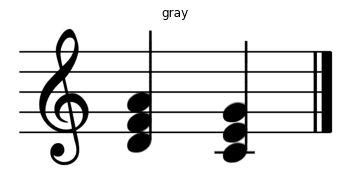

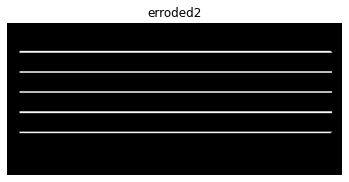

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


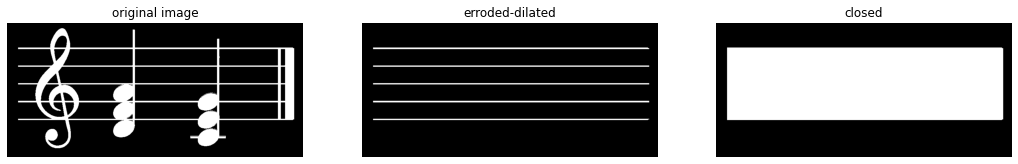

18642


In [14]:
images_paths = [ f"test-cases/0{i+1}.PNG" for i in range(11)]
print(images_paths)

original_image = io.imread(images_paths[6])
gray_image = rgb2gray(original_image)
show_images([gray_image], ['gray'])
binary_image = binarize(gray_image)
inverted_image = 255 - binary_image

inverted_image[:, inverted_image.shape[1]-1]=0
rows=1
cols=original_image.shape[1] // 4
selem = rect(rows,cols)
erroded_img = binary_erosion(inverted_image,selem=selem)

rows=1
cols=original_image.shape[1] // 4
selem = rect(rows,cols)
erroded_img2 = binary_dilation(erroded_img, selem=selem)
# inverted_image2 = inverted_image - erroded_img2

show_images([erroded_img2], ['erroded2'])
print(erroded_img)
rows = original_image.shape[0] // 8
cols = 1
selem = rect(rows,cols)
closed_img  = binary_closing(erroded_img2, selem = selem)


# closed_img  = binary_closing(closed_img, selem = selem)
show_images([inverted_image,erroded_img2,closed_img],['original image','erroded-dilated','closed'])

staffs_area = np.sum(erroded_img2)
print(staffs_area)

In [16]:
#  calculate the trace bounding boxes
trace_bounding_boxes = get_bounding_boxes(closed_img,(1,4000))
# print(trace_bounding_boxes)

bigger_trace_bounding_boxes = []
trace_images_array = []
division_height=0
trace_height = 0

for box in trace_bounding_boxes:
    trace_height = box[3]-box[2]
    trace_width = box[1] - box[0]
    division_height = (trace_height)/4
    division_height = int(np.ceil(division_height)) 
    #  division_height *=2
    [Xmin, Xmax, Ymin, Ymax] = [int(round(x)) for x in box]
    Ymin -= 2 * division_height
    Ymin = Ymin if Ymin >0 else 0
    Ymax += 2 * division_height
    bigger_trace_bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    trace_images_array.append(gray_image[Ymin:Ymax,Xmin:Xmax])

staff_length = bigger_trace_bounding_boxes


In [17]:
SVM_model = pickle.load(open('pickle_model_SVM', 'rb'))
KNN_model = pickle.load(open('pickle_model_KNN', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'pickle_model_KNN'

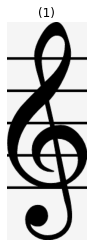

width: 134, height: 367, division_height: 55
oval_centers  []


error: OpenCV(4.5.0) ../modules/objdetect/src/hog.cpp:239: error: (-215:Assertion failed) img.type() == CV_8U || img.type() == CV_8UC3 in function 'computeGradient'


In [18]:
# for each trace segment the individual characters
no_horizontal_staff_images = []
staff_images = []

sh = lambda x: print ("shape is ",x.shape)
line_height = 3
for i, trace in enumerate(bigger_trace_bounding_boxes):
    [Xmin, Xmax, Ymin, Ymax] = [x for x in trace]
    newOrigin = [Xmin,Ymin]
    
    #show_images([original_image[Ymin:Ymax,Xmin:Xmax]], ['ori'])
    no_staf=remove_horizontal_wrapper(original_image[Ymin:Ymax,Xmin:Xmax],inverted_image[Ymin:Ymax,Xmin:Xmax].astype(np.uint8) )
    no_horizontal_staff_images.append(no_staf)
    # show_images([no_staf], ['no_staf'])
    
    char_boxes = get_external_bounding_boxes(no_staf)
    out = draw_external_bounding_boxes(no_staf, char_boxes)
    #show_images([out,no_staf])
    #print(char_boxes)
    # io.imsave('test.jpg', no_staf*255)
    # break
    j=0
    chars = []
    org_chars = []
    trace_info: staff_meta = get_trace_meta(original_image[Ymin:Ymax,Xmin:Xmax])
    # print(trace_info.__dict__)
    
    for box in char_boxes:
        [Xmin, Ymin, W, H] = [x for x in box]
        # remove blank or noisy area that is less than a line of pixels
        char = no_staf[Ymin:Ymin+H,Xmin:Xmin+W]
        org_char = original_image[Ymin+newOrigin[1]:Ymin+H+newOrigin[1],Xmin+newOrigin[0]:Xmin+W+newOrigin[0]]

        # reject noise before appending
        # 1. box area == 0
        if(np.sum(char) == 0):
            continue
        
        # print(filled_holes_centers(char,trace_info.division_height))
        
        radius = int(trace_info.division_height // 3 )
        # padded_char = padd_image(char)        
        # erroded_image = cv2.erode(padded_char,kernel=disk(radius),iterations = 1)        
        # b_boxes = get_external_bounding_boxes(erroded_image)
        
        oval_centers = filled_holes_centers(char, radius)
        #boxes_start_point = Box_localization(char, radius)
        boxes_start_point = Xmin,Ymin
        
        show_images([org_char])
        print("width: {}, height: {}, division_height: {}".format(W,H,trace_info.division_height))
        print("oval_centers ",oval_centers)

        if W < trace_info.division_height//2 and H < trace_info.division_height//2:
            # use the properties of a dot or circle to know for sure it is a dot
            print("this may be a dot or noise")
        else:
            cv_img = org_char.astype(np.uint8)
            hog_f = extract_features(cv_img,'hog')
            
            SVM_model.predict( [hog_f] )
            KNN_model.predict( [hog_f] )
            
            if len(oval_centers) == 0:
                oval_centers = fillingOvals(char,radius)
                if len(oval_centers) == 1:
                    print("this is may be a half, whole or beam")
                elif len(oval_centers) > 1:
                    print("this is may be a chord or beam")
                else:
                    print("this is may be a clef, a number or accidentals noise")
                
            elif len(oval_centers) == 1:
                print("this maybe a quarter or 8th or 16th or 32th or a clef")
                level = get_noteLine_depending_height(oval_centers,boxes_start_point,trace_info)
                
                print(level)
                
            elif len(oval_centers) >= 2:
                # print("this note is beamed or chords")
                # using the x difference between the 1st 2 centre we can separate between chords 
                # or beams
                if oval_centers[1][0] - oval_centers[0][0] > int(1.5*trace_info.division_height):
                    print("this is a beam")
                else:
                    print("this is a chord")
                level = get_noteLine_depending_height(oval_centers,boxes_start_point,trace_info)
                print(level)

        print()
        